# 3. Naive HMM approach

In this notebook, we will fit a HMM with the number of hidden states equal to the unique number of open channels in each batch. This is a naive approach, on which we will improve later on, but already improves upon the simple baseline of just rounding signal values.

In this notebook, we shall only use category 2 (but you can swap it out for others).

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from hmmlearn.hmm import GaussianHMM
from sklearn.metrics import f1_score

In [2]:
# Use the result from previous notebook
train = pd.read_csv('../data/train_2.csv')
test = pd.read_csv('../data/test_2.csv')

In [3]:
BATCHES = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 65, 70])
CATEGORIES = np.array([1, 1, 2, 3, 5, 4, 2, 3, 4, 5, 6, 3, 4, 6, 2, 5, 4, 5, 6, 3, 6, 6])
CATEGORY = 3

signal = np.concatenate((train['signal'].values, test['signal'].values))

ix = np.where(CATEGORIES == CATEGORY)[0]
starts = BATCHES[ix]
ends = BATCHES[ix + 1]

X = []
y = []
for start, end in zip(starts, ends):
    subsignal = signal[start*100_000:end*100_000]
    if start < 50:
        subchannels = train['open_channels'].values[start*100_000:end*100_000]
    else:
        subchannels = [-1]*((end-start)*100_000)
        
    if start == 35:
        subsignal = list(subsignal[:100000]) + list(subsignal[-100000:])
        subchannels = list(subchannels[:100000]) + list(subchannels[-100000:])
    
    X.extend(subsignal)
    y.extend(subchannels)
    
X = np.array(X)
y = np.array(y)
print(len(X), len(y))

900000 900000


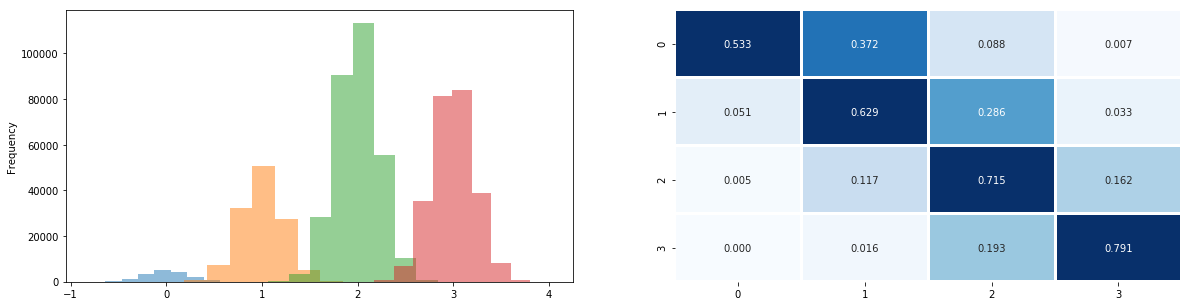

         1     -553328.4852             +nan
         2     -553083.9599        +244.5253
         3     -553070.7632         +13.1966
         4     -553069.2386          +1.5246
         5     -553069.0194          +0.2192
         6     -553068.9844          +0.0350
         7     -553068.9784          +0.0060


In [4]:
def markov_p_trans(states):
    # https://www.kaggle.com/friedchips/the-viterbi-algorithm-a-complete-solution
    max_state = np.max(states)
    states_next = np.roll(states, -1)
    matrix = []
    for i in range(max_state + 1):
        current_row = np.histogram(states_next[states == i], bins=np.arange(max_state + 2))[0]
        if np.sum(current_row) == 0: # if a state doesn't appear in states...
            current_row = np.ones(max_state + 1) / (max_state + 1) # ...use uniform probability
        else:
            current_row = current_row / np.sum(current_row) # normalize to 1
        matrix.append(current_row)
    return np.array(matrix)

f, ax = plt.subplots(1, 2, figsize=(20, 5))

# Estimate the transition matrix based on the ground truth
Ptran = markov_p_trans(y[y >= 0])
sns.heatmap(
    Ptran,
    annot=True, fmt='.3f', cmap='Blues', cbar=False,
    ax=ax[1], vmin=0, vmax=0.5, linewidths=2);


# Estimate means and covs per unique ground truth value
means = []
covs = []
for c in sorted(np.unique(y[y >= 0])):
    pd.Series(X[y == c]).plot(kind='hist', ax=ax[0], alpha=0.5)
    means.append(np.mean(X[y == c]))
    covs.append(np.cov(X[y == c]))
    
plt.show()
    
# Defining our HMM
n_classes = len(np.unique(y[y >= 0]))
hmm = GaussianHMM(
    n_components=n_classes,             # Number of hidden states
    n_iter=50,                          # Total number of iterations
    verbose=True,                       # Show logs
    algorithm='map',                    # Use maximum a posteriori instead of Viterbi
    params='stmc',                      # Optimize start probs, transmat, means, covs
    random_state=42,
    init_params='s',                    # Manually initialize all but start probabilities
    covariance_type='full',             # Separate covariance per hidden state
    tol=0.01                            # Convergence criterion
)

# Initialize the parameters of our HMM
hmm.n_features = 1
hmm.means_ = np.array(means).reshape(-1 ,1)
hmm.covars_ = np.array(covs).reshape(-1, 1, 1)
hmm.transmat_ = Ptran

# Fit our HMM
_ = hmm.fit(X.reshape(-1, 1), lengths=[100000]*(len(X) // 100000))

In [5]:
# Make predictions
preds = hmm.predict(X.reshape(-1, 1), lengths=[100000]*(len(X) // 100000))

# Our rounding baseline
print(f1_score(y[y >= 0], np.clip(np.round(X[y >= 0]).astype(int), 0, np.max(y)), average='macro'))

# Our naive HMM
print(f1_score(y[y >= 0], preds[y >= 0], average='macro'))

0.9738199736256037
0.9840563515575094
